# This is a collection of all the plots used in the variance reduction paper

### To help understand things:
$\phi$ used to be called $h$, and is still called $h$ throughout most of the code and is only relabeled at the very end


For now I will disable all save commands, and reduce the amount of experiments per timestep to speed things up 



## ToDo:



## Done


### Important parameters

In [1]:
alpha_default  = 0.1 #Reguralization coeffcient for sensitivity calculation

In [2]:
from da_functions import *
from model_functions import *
from plot_functions import *
from misc_functions import *

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(color_codes = True)
sns.set_style('whitegrid')
import pickle

In [3]:
# I need this for some reason so that autocomplete works
%config Completer.use_jedi = False

# Running the default run that is used for the illustration plots and to generate the initial conditions for the variance reduction tests

In [4]:
"""
initialize model and data assimilation setup using the default values
"""
m_const = set_model_constants_22()
da_const = set_da_constants_22()
sat_operator = reflectance_simulator


In [5]:
%%time
# Run the model for the 100 time steps
states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)

CPU times: user 6.72 s, sys: 188 ms, total: 6.9 s
Wall time: 1.91 s


### Plotting the first two and last three timesteps

/home/pgriewank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  


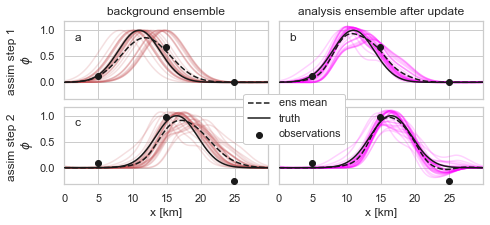

In [6]:
fig, ax = ensemble_plotter_22(states,m_const,da_const,t_start=1,t_end=3)
ax[1,0].set_xticklabels(['0','5','10','15','20','25'])
ax[0,0].set_title('background ensemble')
ax[1,0].set_xlabel('x [km]')
ax[1,1].set_xlabel('x [km]')
ax[0,0].set_ylabel('assim step 1 \n' +r'$\phi$')
ax[1,0].set_ylabel('assim step 2 \n' +r'$\phi$')
ax[1,1].legend(bbox_to_anchor=(-0.2,0.45),loc=3,framealpha=1.)
plt.subplots_adjust(wspace=0.05,hspace=0.1)
label_axes_abcd(fig,loc=(0.05,0.75))

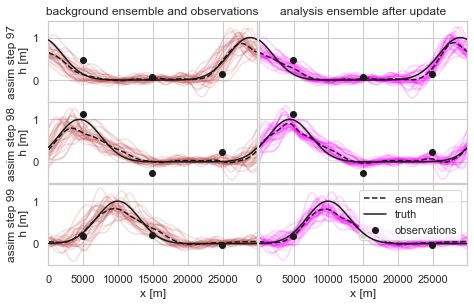

In [7]:
fig, ax = ensemble_plotter_22(states,m_const,da_const,t_start=da_const['ncyc']-3)


# plotting the indirect observations in additions to the direct observations for one timestep


In [8]:
%%time
t_step = 40
bg = states[0]['bg'][t_step]
an = states[0]['an'][t_step]
truth = states[0]['truth'][t_step]
obs = states[0]['obs'][t_step] 
obs_sat = states[0]['obs_sat'][t_step] 

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 16.9 µs


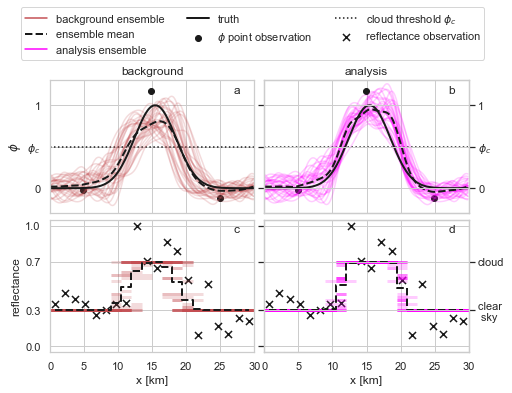

In [9]:
fig,ax = plot_ensemble_sat_analysis_paper(bg,an,obs,obs_sat,truth,reflectance_simulator,m_const,da_const,h_c=0.5)

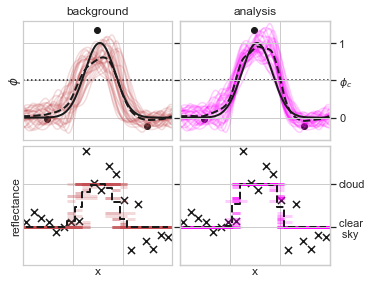

In [10]:
fig,ax = plot_ensemble_sat_analysis_abstract(bg,an,obs,obs_sat,truth,reflectance_simulator,m_const,da_const,h_c=0.5)

# Running single OSSE experiments

In [11]:

da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests

-119.38467652972545 -123.63563524670326


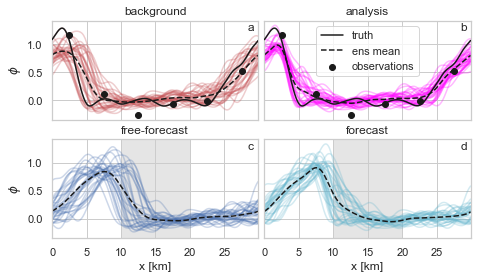

In [12]:
t_step=43
truth_idx=7
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_vr,sat_operator,alpha=alpha_default,obs_seed=22)
fig, ax = quad_plotter_paper(quad,m_const,da_const_vr)
label_axes_abcd(fig,loc=(0.95,0.9))
print(vr_t,vr_r)

In [13]:
def plot_J_quad_paper(J_dict,quad,sens,dx,bw=0.3,dJ=True):
    """
    Plots the forecast metric distributions of the free forecast, forecast, and their linear approximations for the given sensitivity
    """
    
    fig = plt.figure(figsize=(4,3))
    nens = len(J_dict['bf'])
    dX_bg=(quad['bg'].T-np.mean(quad['bg'],axis=1)).T
    dX_an=(quad['an'].T-np.mean(quad['an'],axis=1)).T
    dX_an=dx
    dJ_ff=np.dot(sens,dX_bg)
    dJ_fc=np.dot(sens,dX_an)
    print('vr_reductions:',np.var(dJ_fc,ddof=1)-np.var(dJ_ff,ddof=1 ),np.var(J_dict['fc'],ddof=1)-np.var(J_dict['bf'],ddof=1))
    print('variance:',np.var(J_dict['bf'],ddof=1),np.var(dJ_ff,ddof=1),np.var(J_dict['fc'],ddof=1),np.var(dJ_fc,ddof=1 ))
            #'response' : np.hstack([J_dict['bf']-np.mean(J_dict['bf']),dJ_ff,J_dict['fc']-np.mean(J_dict['fc']),J_dict['es']-np.mean(J_dict['es'])]),
    if dJ:
        plot_data = {
            'response' : np.hstack([J_dict['bf']-np.mean(J_dict['bf']),dJ_ff,J_dict['fc']-np.mean(J_dict['fc']),dJ_fc]),
            'x_pos'    : np.hstack([np.zeros(nens)+0,np.zeros(nens)+1,np.zeros(nens)+2,np.zeros(nens)+3]),
            'type'     : ['blindforecast']*nens+['estimated']*nens+['forecast']*nens}
    else:
        plot_data = {
            'response' : np.hstack([J_dict['bf'],dJ_ff+np.mean(J_dict['bf']),J_dict['fc'],dJ_fc+np.mean(J_dict['fc'])]),
            'x_pos'    : np.hstack([np.zeros(nens)+0,np.zeros(nens)+1,np.zeros(nens)+2,np.zeros(nens)+3]),
            'type'     : ['blindforecast']*nens+['estimated']*nens+['forecast']*nens}

    my_pal = ["blue",  "peru","cyan","orange"  ]
        
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    }
    #ax = sns.violinplot(data=plot_data, inner='quartile', orient="v",cut=0,bw=bw,y='response',x='x_pos',palette=my_pal)#sns.color_palette('cool',n_colors=3))#,x='type')#,y='response',x='cyc',hue='type',,split=True,palette={dict_label[left_var]:dict_color[left_var],dict_label[right_var]:dict_color[right_var]}
    ax = sns.stripplot(data=plot_data, y='response',x='x_pos',alpha=0.7,jitter=0.15,size=5,palette=my_pal)#color='0.0')#
    #ax = sns.boxplot(data=plot_data, y='response',x='x_pos',showfliers=False,**PROPS)#,patch_artist=False)#color='0.0')#,palette=my_pal
    #plot errorbars
    plt.errorbar(np.arange(4),np.zeros(4),[np.std(J_dict['bf'],ddof=1),np.std(dJ_ff,ddof=1),np.std(J_dict['fc'],ddof=1),np.std(dJ_fc,ddof=1 )],fmt='.',capsize=15,lw=3,color='k') 
    
    #if dJ == False: ax.hlines(J_dict['tr_fc'],-0.5,2.5,'k',ls='--',label='truth'); plt.legend()
    #if dJ: ax.hlines(0,-0.5,3.5,'k',ls='--') 
    ax.set_xlim(-0.5,3.5)
    if dJ == False: ax.set_ylabel(r'$j$')
    if dJ: ax.set_ylabel(r'$\delta j$')
    ax.set_xticklabels(['free-\nforecast','estimated \n free-forecast','\n forecast','estimated \n forecast'])
    return fig, ax

vr_reductions: -119.38467652972545 -123.63563524670326
variance: 221.43278926594013 176.91208076683142 97.79715401923687 57.52740423710596


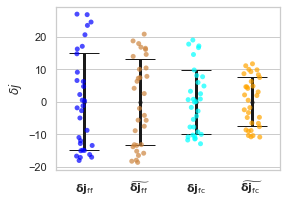

In [14]:
fig,ax = plot_J_quad_paper(J_dict,quad,dJdx_inv,dx,bw=0.2)
#ax.set_ylim(-70,55)
import matplotlib as mpl
ax.set_ylabel(r'$\mathbf{\delta j}$')
ax.set_ylabel(r'$ \delta j$')
ax.set_xticklabels([r'$\mathbf{\delta j}_\mathrm{ff}$',r'$\widetilde{\mathbf{\delta j}_\mathrm{ff}}$',r'$\mathbf{\delta j}_\mathrm{fc}$',r'$\widetilde{\mathbf{\delta j}_\mathrm{fc}}$'],va='bottom')
ax.tick_params(axis='x', pad=20)

# Sensitivity plots of the regularized sensitivity and the sensitivity which ignores crosscorrelations

We have to rerun the default run but with 512 ensemble members, and then make two OSSEs for 300 and 600 seconds.


Uncomment plot commands to see the intermediate steps plotted

In [15]:
da_const_512 = set_da_constants_22(nens=512,ncyc=t_step+1)
da_const_6   = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=300)
da_const_62  = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=600)
t_step=23
truth_idx=11

In [16]:
%%time
# Run the model and the single OSSEs, from which we only need the quads
states   = run_linear_advection_KF_22(m_const,da_const_512,reflectance_simulator)
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad , dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_6,sat_operator,model_seed=505,obs_seed=55)
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad2, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_62,sat_operator,model_seed=505,obs_seed=55)

/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  bg[:,i]    = linear_advection_model(analysis[:,i],u_ens,dhdt_ens,m_const["dx"],da_const["dt"],da_const["nt"])


CPU times: user 11.4 s, sys: 292 ms, total: 11.7 s
Wall time: 3 s


In [17]:
#fig, ax = ensemble_plotter_22(states,m_const,da_const_512,t_end=4)

#fig, ax = quad_plotter_22(quad,m_const,da_const_6)

#fig, ax = quad_plotter_22(quad2,m_const,da_const_62)

In [18]:


def L2_ensemble_limit(quad,nens,alpha=None,dt=0):
    """
    Simple function that calculates the sensitivity for a given quad"""
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = sum_mid_tri(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
    dJ = J-np.mean(J)
    B = np.cov(dX,ddof=1)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    sens = L2_regularized_inversion(B,cov_dJdX,alpha=alpha)
    return sens


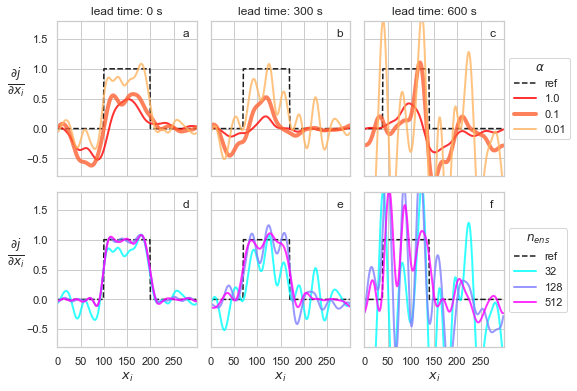

In [19]:
fig,ax = plt.subplots(2,3,sharex='all',sharey='all',figsize=(8,6))

alpha_list = [1.,0.1,0.01]
nens_list = [2**5,2**7,2**9]
#Reference lines
ax[0,0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')
ax[1,0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')

x_advected = np.array([0,99,100,199,200,299])-da_const_6['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[0,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
ax[1,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = np.array([0,99,100,199,200,299])-da_const_62['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[0,2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
ax[1,2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
#ax[2,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')

#First all the ensemble ones
n_lines = len(nens_list)
for i in range(n_lines):
    nens = nens_list[i]
    linewidth=2
#     if nens==32: linewidth=4
    ax[1,0].plot(L2_ensemble_limit(quad ,nens,dt=0,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)
    ax[1,1].plot(L2_ensemble_limit(quad ,nens,dt=1,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)
    ax[1,2].plot(L2_ensemble_limit(quad2,nens,dt=1,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)


n_lines = len(alpha_list)
for i in range(n_lines):
    linewidth=2
    if alpha_list[i]==0.1: linewidth=4
    ax[0,0].plot(L2_ensemble_limit(quad ,32,dt=0,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)
    ax[0,1].plot(L2_ensemble_limit(quad ,32,dt=1,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)
    ax[0,2].plot(L2_ensemble_limit(quad2,32,dt=1,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)

ax[0,1].set_ylim(-0.8,1.8)

ax[0,1].set_xlim(0.,300)
ax[0,1].set_xticks(50*np.arange(0,6));
plt.subplots_adjust(hspace=0.1,wspace=0.1)


ax[1,2].legend(title=r'$n_{ens}$',ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[0,2].legend(title=r'$\alpha$' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[1,0].set_xlabel(r'$x_i$',size=13)
ax[1,1].set_xlabel(r'$x_i$',size=13)
ax[1,2].set_xlabel(r'$x_i$',size=13)
ax[0,0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)
ax[1,0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)

ax[0,0].set_title('lead time: 0 s')
ax[0,1].set_title('lead time: '+str(da_const_6['dt']) +' s')
ax[0,2].set_title('lead time: '+str(da_const_62['dt'])+' s')
label_axes_abcd(fig)

In [20]:
def var_ensemble_limit(quad,t,nens,dt=0,response_func = sum_mid_tri):
    """
    Looking into the cov(dJ,dX)/var(dX) simplification
    """
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = response_func(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
        
    dJ = J-np.mean(J)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    return cov_dJdX/np.var(dX,axis=1,ddof=1)


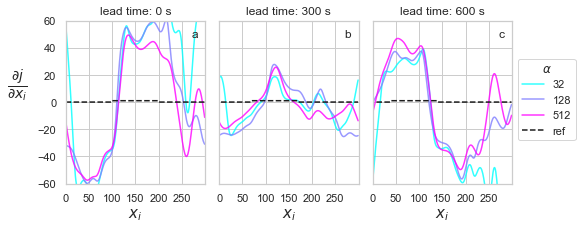

In [21]:
#Looking into the var simplification that we know doesn't work, but might be worth showing anyway 
fig,ax = plt.subplots(1,3,sharex='all',sharey='all',figsize=(8,3))
#nens_list = [2**3,2**5,2**7,2**9]
nens_list = [2**5,2**7,2**9]
n_lines = len(nens_list)
for i in range(n_lines):
    nens = nens_list[i]
    ax[0].plot(var_ensemble_limit(quad,20,nens,dt=0),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))
    ax[1].plot(var_ensemble_limit(quad,20,nens,dt=1),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))
    ax[2].plot(var_ensemble_limit(quad2,20,nens,dt=1),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))

x_advected = np.array([0,99,100,199,200,299])-da_const_6['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = np.array([0,99,100,199,200,299])-da_const_62['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')

plt.subplots_adjust(hspace=0.1,wspace=0.1)
ax[0].set_xlim(0.,300)
ax[0].set_xticks(50*np.arange(0,6));

ax[0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')
# ax[0].legend(title=r'$n_{ens}$',ncol=3,bbox_to_anchor=(0,1.0),loc='lower left')
ax[2].legend(title=r'$\alpha$' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[0].set_xlabel(r'$x_i$',size=15)
ax[1].set_xlabel(r'$x_i$',size=15)
ax[2].set_xlabel(r'$x_i$',size=15)
ax[0].set_title('lead time: 0 s')
ax[1].set_title('lead time: '+str(da_const_6['dt']) +' s')
ax[2].set_title('lead time: '+str(da_const_62['dt'])+' s')
ax[0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=20,labelpad=20)
ax[0].set_xlim(0.,300)
#plt.xticks(32*np.arange(9));
ax[0].set_ylim(-60,60)
label_axes_abcd(fig)

# Now making the localization advection scetch

In [22]:
"""
Reinitializing to the default values, and calculating the localization matrices
"""
m_const = set_model_constants_22()
da_const = set_da_constants_22()
L_obs,L_os = localization_matrices_observation_space(m_const,da_const)


(0.0, 30.0)

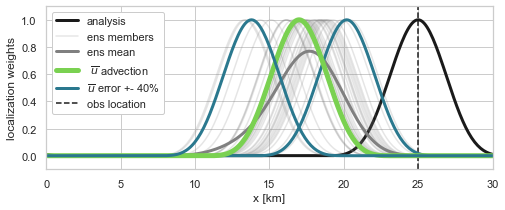

In [23]:
# This one has the plus 50 and minus 50 error, and also follows the color scheme of the other plot
o = 2
np.random.seed(2)
u_advect=10
dt = 800
L_adv_mean = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect,dt)
L_adv_plus = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect*1.4,dt)
L_adv_minu = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect*0.6,dt)
L_adv_ens = np.zeros([m_const['nx'],da_const['nens']])
for n in range(da_const['nens']):
    u_ens = np.random.normal(m_const['u_ref'],da_const['u_std_ens'])
    L_adv_ens[:,n] =semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_ens,dt)  

    
fig, ax = plt.subplots(1,1,figsize=(8,3))


linew = (10-np.abs(60-100)/10)/2



plt.vlines(da_const['obs_loc'][o]/10+0.1,-0.1,1.1,ls='--',color='k',label='obs location')
plt.plot(m_const['x_grid']/1000+0.1,L_os[:,o],lw=3,color='k',label='analysis')
for n in range(da_const['nens']-1):
    plt.plot(m_const['x_grid']/1000+0.1,L_adv_ens[:,n],'grey',alpha=0.2)
plt.plot(m_const['x_grid']/1000+0.1,L_adv_ens[:,n+1],'grey',alpha=0.2,label='ens members')
plt.plot(m_const['x_grid']/1000+0.1,np.mean(L_adv_ens[:,:],axis=1),'grey',lw=3,label='ens mean')

plt.plot(m_const['x_grid']/1000+0.1,L_adv_minu,lw=linew,color=plt.cm.viridis((2)/(5)))
plt.plot(m_const['x_grid']/1000+0.1,L_adv_mean,lw=5,color=plt.cm.viridis((4)/(5)),label=' $\overline{u}$ advection')
plt.plot(m_const['x_grid']/1000+0.1,L_adv_plus,lw=linew,color=plt.cm.viridis((2)/(5)),label='$\overline{u}$ error +- 40%')
   
#plt.plot(m_const['x_grid']/1000,L_adv_mean,lw=3,color='r')
#plt.vlines(da_const['obs_loc'][o]/10+u_advect*dt/1000,-0.1,1.1,ls='--',color='r')
#plt.legend(loc='upper center',ncol=3)
plt.legend(framealpha=1)
ax.set_xlabel('x [km]')
ax.set_ylabel('localization weights')
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,30)

# Calculating the lead time dependent plots from the paper with and without advection errors

this is relatively time consuming, because for each of the 11 forecast lead times the 900 OSSEs need to be done with the explicit, implicit, and the implicit with 8 different lead times

In [92]:
%%time
# just resetting a
m_const = set_model_constants_22()
da_const = set_da_constants_22()
sat_operator = reflectance_simulator
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests
# Run the model
states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


CPU times: user 4.46 s, sys: 51.7 ms, total: 4.51 s
Wall time: 1.16 s


In [96]:
%%time
import time
start_time=time.process_time()

t_start= 40
t_end = 100
n_ens = 15
#n_ens = 5 # Comment out for full data
ndt_steps=11
nerrors = 8
error_vec = [20,40,60,80,120,140,160,180]
t_vec=np.linspace(0,1000,ndt_steps)
n_samples = (t_end-t_start)*n_ens
truth_idx = 0
sens_all     = np.zeros([ndt_steps,300])
vr_es        = np.zeros([ndt_steps,n_samples])
vr_es_hi     = np.zeros([ndt_steps,n_samples])
vr_is_ca     = np.zeros([ndt_steps,n_samples])
vr_is_cw     = np.zeros([nerrors,ndt_steps,n_samples])
vr_real      = np.zeros([ndt_steps,n_samples]) 
var_total     = np.zeros([ndt_steps,n_samples]) 
ref_t = da_const['dt']
t_vec[0] = 1
counter = 0
for t in range(t_start,t_end):
    for n in range(n_ens):
        i = (t-t_start)*n_ens+n
        counter = counter+1
        truth_idx = n
        for dt in range(len(t_vec)): 
            da_const_vr['dt'] = t_vec[dt]
            
            vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
                states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
                obs_seed=i,model_seed=i,alpha=alpha_default)
            sens_all[dt,:]= sens_all[dt,:]+dJdx_inv/n_ens/(t_end-t_start)
            var_total[dt,i] = np.var(J_dict['bf'],ddof=1)
            vr_es[dt,i]     = vr_t
            vr_real[dt,i]   = vr_r
            
            
            vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
                                                  advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
            vr_is_ca[dt,i]  = vr_t
            
            for e in range(nerrors):
                vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
                                                  advect_flag=1,obs_seed=i,model_seed=i,error_u=error_vec[e],quad_state=quad)
                vr_is_cw[e,dt,i]  = vr_t
            
    if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))

completed timesteps: 1  seconds spent computing so far: 61.0
completed timesteps: 11  seconds spent computing so far: 727.0
completed timesteps: 21  seconds spent computing so far: 1421.0
completed timesteps: 31  seconds spent computing so far: 2131.0
completed timesteps: 41  seconds spent computing so far: 2775.0
completed timesteps: 51  seconds spent computing so far: 3465.0
CPU times: user 1h 7min 30s, sys: 59 s, total: 1h 8min 29s
Wall time: 17min 9s


In [97]:
# calculating the mean properties over all experiments
es    =np.sum(vr_es    ,axis=1)/counter
is_ca =np.sum(vr_is_ca ,axis=1)/counter
real  =np.sum(vr_real  ,axis=1)/counter
total =np.sum(var_total,axis=1)/counter

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter

std_real    =np.std(vr_real,axis=1)

rmse_is_cw =np.zeros([nerrors,ndt_steps])
is_cw =np.zeros([nerrors,ndt_steps])

for e in range(nerrors):
    rmse_is_cw[e,:] =np.power(np.sum(np.power((vr_is_cw[e,:,:] -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
    is_cw[e,:] =np.sum(vr_is_cw[e,:,:] ,axis=1)/counter#/var_total


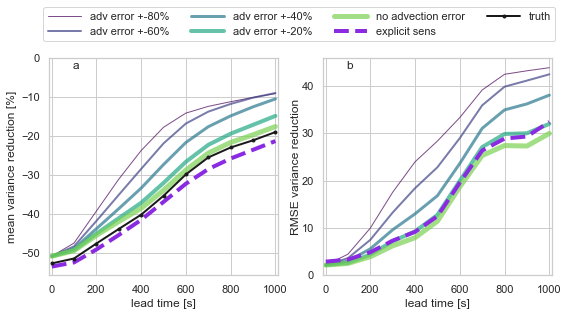

In [98]:
fig,ax = plt.subplots(1,2,figsize=(9,4),sharex='all')
for e in range(4):
    alpha = np.abs(error_vec[e]-100)/100
    alpha = 1-alpha/2
    alpha = 1.0
    linew = 10-np.abs(error_vec[e]-100)/10
    linew = linew/2
    label='adv error +-'+str(np.abs(error_vec[e]-100))+'%'
    #ax[0].plot(t_vec, 100*(is_cw[e,:]+is_cw[-e-1,:] )/total/2  , lw=linew,color='mediumseagreen',alpha=alpha,linestyle='-.',label=label)
    ax[0].plot(t_vec, 100*(is_cw[e,:]+is_cw[-e-1,:] )/total/2  , lw=linew,alpha=0.7,linestyle='-',label=label,color=plt.cm.viridis((e)/(5)))
    #ax[0].plot(t_vec, 100*(is_cw[e,:]+is_cw[-e-1,:] )/total/2  , lw=linew,alpha=alpha,linestyle='-.',label=label,color=plt.cm.viridis(e/(6-1)))
    ax[1].plot(t_vec, rmse_is_cw[e,:] *real  , lw=linew,linestyle='-',label=label,color=plt.cm.viridis((e)/(5)),alpha=0.7)
    
ax[0].plot(t_vec,100* is_ca/total   , lw=5,alpha=0.7,label='no advection error',color=plt.cm.viridis((4)/(6-1)))
ax[0].plot(t_vec,100* es/total   , lw=4,label='explicit sens'              ,color='blueviolet',ls='--')      
ax[0].plot(t_vec,100* real /total   , lw=2,alpha=1,  color='k'  ,ls='-' ,marker='.',label='truth')
# ax[0].errorbar(t_vec,100* real /total   ,std_real*100/total,lw=2,alpha=1,  color='k'  ,ls='-' ,marker='.',label='truth')
ax[1].plot(t_vec,rmse_is_ca*real    , lw=5,alpha=0.7,label='implicit sens',color=plt.cm.viridis((4)/(6-1)))
ax[1].plot(t_vec,rmse_es*real    , lw=4,alpha=1.0,label='exp sens'              ,color='blueviolet',ls='--')      


ax[0].set_xlabel('lead time [s]');
ax[1].set_xlabel('lead time [s]');
ax[0].set_ylabel('mean variance reduction [%]');
ax[1].set_ylabel('RMSE variance reduction',labelpad=0.1);
ax[1].set_ylim(bottom=0)
ax[0].set_ylim(top=0)
ax[0].set_xlim(left=-10,right=1010)

ax[0].legend(bbox_to_anchor=(-0.05,1.05),loc='lower left',ncol=4,handlelength=3);
plt.subplots_adjust(hspace=0.2)
label_axes_abcd(fig,loc=(0.1,0.95))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


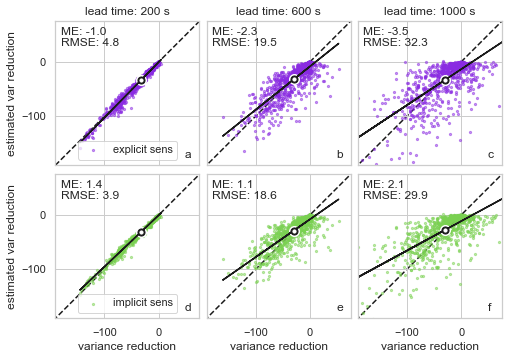

In [99]:
ind_list = [2,6,10]

fig,ax = vr_scatter_v6(vr_es[ind_list[0],:],vr_real[ind_list[0],:],vr_es[ind_list[1],:],vr_real[ind_list[1],:],vr_es[ind_list[2],:],vr_real[ind_list[2],:],
                       vr_is_ca[ind_list[0],:],vr_is_ca[ind_list[1],:],vr_is_ca[ind_list[2],:],
                       alpha=0.5,
                       label1='lead time: ' +str(int(t_vec[ind_list[0]]))+' s',
                       label2='lead time: ' +str(int(t_vec[ind_list[1]]))+' s',
                       label3='lead time: ' +str(int(t_vec[ind_list[2]]))+' s')
ax[0,0].set_xlim(-190,75)
ax[0,0].set_ylim(-190,75)

for i in range(3):
    rmse = int(10*rmse_es[ind_list[i]]*real[ind_list[i]])
    me = int(10*me_es[ind_list[i]]*real[ind_list[i]])
    ax[0,i].text(-180,30,'RMSE: '+str(rmse/10),ha='left')
    ax[0,i].text(-180,50,'ME: '+str(me/10),ha='left')
for i in range(3):
    rmse = int(10*rmse_is_ca[ind_list[i]]*real[ind_list[i]])
    me = int(10*me_is_ca[ind_list[i]]*real[ind_list[i]])
    ax[1,i].text(-180,30,'RMSE: '+str(rmse/10),ha='left')
    ax[1,i].text(-180,50,'ME: '+str(me/10),ha='left')
label_axes_abcd(fig,loc=(0.9,0.05))

# Now looking into the effect of the localization length scale

Very similar to the advection speed

In [29]:
%%time
import time
start_time=time.process_time()

t_start= 40
t_end = 100
n_ens = 15
n_ens = 2

n_samples = (t_end-t_start)*n_ens
truth_idx = 0

loc_values = 2.**np.arange(11)*m_const['dx']
vr_es        = np.zeros([11,n_samples])
vr_is_cl     = np.zeros([11,n_samples])
vr_is_ca     = np.zeros([11,n_samples])
vr_is_it     = np.zeros([11,n_samples])
vr_real      = np.zeros([11,n_samples]) 
var_total     = np.zeros([11,n_samples]) 
counter = 0
for t in range(t_start,t_end):
    for r in range(n_ens):
        n = (t-t_start)*n_ens+r
        np.random.seed(n)
        counter = counter+1
        truth_idx = r
        for i in range(len(loc_values)): 
                
            da_const_vr = set_da_constants_22(loc_length=loc_values[i],obs_loc=np.arange(25,299,50))
            
            vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
                                                                        obs_seed=counter,model_seed=counter,alpha=alpha_default)
            var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
            vr_es[i,n]     = vr_t
            vr_real[i,n]   = vr_r
            
            
            vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states[0]['bg'][t][:,:],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,quad_state=quad,advect_flag=0,obs_seed=counter,model_seed=counter)
            vr_is_cl[i,n]  = vr_t
            vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states[0]['bg'][t][:,:],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,advect_flag=1,quad_state=quad,obs_seed=counter,model_seed=counter)
            vr_is_ca[i,n]  = vr_t
    if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))
       

completed timesteps: 1  seconds spent computing so far: 287.0
completed timesteps: 11  seconds spent computing so far: 321.0
completed timesteps: 21  seconds spent computing so far: 356.0
completed timesteps: 31  seconds spent computing so far: 393.0
completed timesteps: 41  seconds spent computing so far: 432.0
completed timesteps: 51  seconds spent computing so far: 473.0
CPU times: user 3min 40s, sys: 3.5 s, total: 3min 44s
Wall time: 56.2 s


In [31]:
es    =np.sum(vr_es    ,axis=1)/counter#/var_total
is_cl =np.sum(vr_is_cl ,axis=1)/counter#/var_total
is_ca =np.sum(vr_is_ca ,axis=1)/counter#/var_total
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

sample_uncertainty =np.std(vr_real[:,:] ,axis=1)/np.mean(vr_real,axis=1)/30
sample_uncertainty_es =np.std(vr_es[:,:] ,axis=1)/np.mean(vr_real,axis=1)/30
sample_uncertainty_ca =np.std(vr_is_ca[:,:] ,axis=1)/np.mean(vr_real,axis=1)/30

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_cl =np.sum((vr_is_cl -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter
rmse_is_cl =np.power(np.sum(np.power((vr_is_cl -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter

std_real    =np.std(vr_real,axis=1)

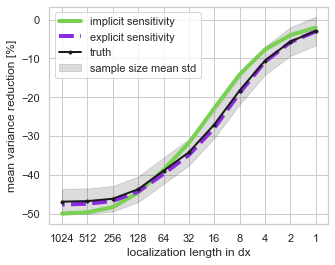

In [32]:
#Lets see what changes when we change the localization used to create the background
fig,ax = plt.subplots(1,figsize=(5,4),sharex='all')
#plt.yscale('symlog',linthresh=0.001)
# ax.plot(np.arange(11,0,-1), is_it/total*100    , lw=3,alpha=0.8,label='imp sens, iterative    ',color='darkolivegreen')
# ax.plot(np.arange(11,0,-1), is_cl/total*100    , lw=4,alpha=0.8,label='imp sens, localized    '           ,color='green',zorder=2) 
ax.plot(np.arange(11,0,-1), is_ca/total*100    , lw=4,alpha=1.0,label='implicit sensitivity',color=plt.cm.viridis((4)/(6-1)))
ax.plot(np.arange(11,0,-1), es   /total*100    , lw=4,alpha=1.0,label='explicit sensitivity'              ,color='blueviolet',ls='--')      
ax.plot(np.arange(11,0,-1), real /total*100    , lw=2,alpha=1,  color='k',ls='-',marker='.',label='truth')

#ax.errorbar(np.arange(11,0,-1),real /total*100   ,yerr=sample_uncertainty*100,color='k',label='truth',capsize=5)

ax.fill_between(np.arange(11,0,-1),real /total*100  -sample_uncertainty*100 ,real /total*100+sample_uncertainty*100,color='k',alpha=0.15,label='sample size mean std')

ax.set_xlabel('localization length in dx');
ax.set_ylabel('mean variance reduction [%]');
ax.set_xticks(np.arange(1,12));
ax.set_xticklabels(2**np.arange(10,-1,-1));
#ax.legend(bbox_to_anchor=(-0.3,1.05),loc='lower left',ncol=5);
l=ax.legend(loc='upper left',ncol=1);
l.set_zorder(1)
plt.subplots_adjust(hspace=0.2)

# Comparison between observations

In [37]:
%%time
import time
start_time=time.process_time()
da_const_sur = set_da_constants_22(obs_loc=np.arange(25,299,50),obs_loc_sat=np.array([]))
da_const_sat = set_da_constants_22(obs_loc=np.array([]))
t_start= 40
t_end = 100
n_ens = 15
# n_ens = 2
n_samples = (t_end-t_start)*n_ens
truth_idx = 0
vr_es         = np.zeros(n_samples)
vr_is_ca      = np.zeros(n_samples)
vr_real       = np.zeros(n_samples) 
var_total     = np.zeros(n_samples) 
sat_vr_es         = np.zeros(n_samples)
sat_vr_is_ca      = np.zeros(n_samples)
sat_vr_real       = np.zeros(n_samples) 
sat_var_total     = np.zeros(n_samples) 
sur_vr_es         = np.zeros(n_samples)
sur_vr_is_ca      = np.zeros(n_samples)
sur_vr_real       = np.zeros(n_samples) 
sur_var_total     = np.zeros(n_samples) 
counter = 0
for t in range(t_start,t_end):
    for n in range(n_ens):
        i = (t-t_start)*n_ens+n
        #print(i,n_obs)
        counter = counter+1
        truth_idx = n

        # point obs
            
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
            states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sur,reflectance_simulator,
            obs_seed=i,model_seed=i,alpha=alpha_default)
        sur_var_total[i] = np.var(J_dict['bf'],ddof=1)
        sur_vr_es[i]     = vr_t
        sur_vr_real[i]   = vr_r
        
        vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sur,reflectance_simulator,
                                              advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
        sur_vr_is_ca[i]  = vr_t
        
        
        # sat obs
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
            states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sat,reflectance_simulator,
            obs_seed=i,model_seed=i,alpha=alpha_default)
        sat_var_total[i] = np.var(J_dict['bf'],ddof=1)
        sat_vr_es[i]     = vr_t
        sat_vr_real[i]   = vr_r
        
        vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sat,reflectance_simulator,
                                              advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
        sat_vr_is_ca[i]  = vr_t
        
        
        # both obs
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
            states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
            obs_seed=i,model_seed=i,alpha=alpha_default)
        var_total[i] = np.var(J_dict['bf'],ddof=1)
        vr_es[i]     = vr_t
        vr_real[i]   = vr_r
        
        vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
                                              advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
        vr_is_ca[i]  = vr_t
        
    if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))
       

completed timesteps: 1  seconds spent computing so far: 3.0
completed timesteps: 11  seconds spent computing so far: 51.0
completed timesteps: 21  seconds spent computing so far: 97.0
completed timesteps: 31  seconds spent computing so far: 150.0
completed timesteps: 41  seconds spent computing so far: 203.0
completed timesteps: 51  seconds spent computing so far: 255.0
CPU times: user 4min 58s, sys: 4.4 s, total: 5min 2s
Wall time: 1min 15s


In [38]:
sur_es    =np.sum(sur_vr_es    )/counter#/var_total
sur_is_ca =np.sum(sur_vr_is_ca )/counter#/var_total
sur_real  =np.sum(sur_vr_real  )/counter#/var_total
sat_es    =np.sum(sat_vr_es    )/counter#/var_total
sat_is_ca =np.sum(sat_vr_is_ca )/counter#/var_total
sat_real  =np.sum(sat_vr_real  )/counter#/var_total
es    =np.sum(vr_es    )/counter#/var_total
is_ca =np.sum(vr_is_ca )/counter#/var_total
real  =np.sum(vr_real  )/counter#/var_total
total =np.sum(var_total)/counter#/var_total

sur_me_es    =np.sum((sur_vr_es    -sur_vr_real))/np.sum(sur_vr_real)
sur_me_is_ca =np.sum((sur_vr_is_ca -sur_vr_real))/np.sum(sur_vr_real)
sat_me_es    =np.sum((sat_vr_es    -sat_vr_real))/np.sum(sat_vr_real)
sat_me_is_ca =np.sum((sat_vr_is_ca -sat_vr_real))/np.sum(sat_vr_real)
me_es    =np.sum((vr_es    -vr_real))/np.sum(vr_real)
me_is_ca =np.sum((vr_is_ca -vr_real))/np.sum(vr_real)

sat_rmse_es    =np.power(np.sum(np.power((sat_vr_es    -sat_vr_real),2))/counter,0.5)/np.sum(sat_vr_real)*counter
sat_rmse_is_ca =np.power(np.sum(np.power((sat_vr_is_ca -sat_vr_real),2))/counter,0.5)/np.sum(sat_vr_real)*counter
sur_rmse_es    =np.power(np.sum(np.power((sur_vr_es    -sur_vr_real),2))/counter,0.5)/np.sum(sur_vr_real)*counter
sur_rmse_is_ca =np.power(np.sum(np.power((sur_vr_is_ca -sur_vr_real),2))/counter,0.5)/np.sum(sur_vr_real)*counter
rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2))/counter,0.5)/np.sum(vr_real)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2))/counter,0.5)/np.sum(vr_real)*counter

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


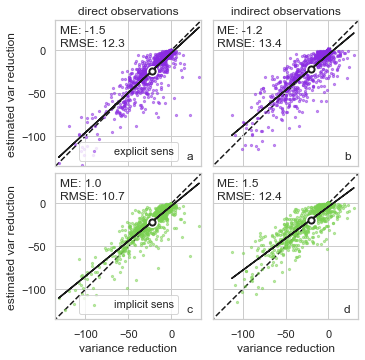

In [40]:

fig,ax = vr_scatter_v4(sur_vr_es,sur_vr_real,sat_vr_es,sat_vr_real,
                       sur_vr_is_ca,sat_vr_is_ca,
                       alpha=0.5,
                       label1='direct observations',
                       label2='indirect observations')
ax[0,0].set_xlim(-135,35)
ax[0,0].set_ylim(-135,35)

# for i in range(3):
rmse = int(10*sur_rmse_es*sur_real)
me = int(  10*sur_me_es  *sur_real)
ax[0,0].text(-130,5,'RMSE: '+str(rmse/10),ha='left')
ax[0,0].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sat_rmse_es*sat_real)
me = int(  10*sat_me_es  *sat_real)
ax[0,1].text(-130,5,'RMSE: '+str(rmse/10),ha='left')
ax[0,1].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sur_rmse_is_ca*sur_real)
me = int(  10*sur_me_is_ca  *sur_real)
ax[1,0].text(-130,5,'RMSE: '+str(rmse/10),ha='left')
ax[1,0].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sat_rmse_is_ca*sat_real)
me = int(  10*sat_me_is_ca  *sat_real)
ax[1,1].text(-130,5,'RMSE: '+str(rmse/10),ha='left')
ax[1,1].text(-130,20,'ME: '+str(me/10),ha='left')
label_axes_abcd(fig,loc=(0.9,0.05))

# Next up testing for different regularization parameters alpha

This takes long enough (hour), that I will simply load the data instead of running it by default 


In [31]:
# %%time
# da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50))

# nalpha_steps=23
# alpha_vec=np.logspace(-9,2,nalpha_steps)
# t_vec=np.array([200,600,1000,1400,1800])
# ndt_steps=len(t_vec)
# t_start= 40
# t_end = 100
# n_rand = 15
# n_samples = (t_end-t_start)*n_rand
# sens_all     = np.zeros([ndt_steps,300])
# vr_es_alpha  = np.zeros([nalpha_steps,ndt_steps,n_samples])
# vr_real      = np.zeros([ndt_steps,n_samples]) 
# var_total     = np.zeros([ndt_steps,n_samples]) 
# counter = 0
# total_variance = 0.
# for t in range(t_start,t_end):
#     for r in range(n_rand):
#         n = (t-t_start)*n_rand+r
#         np.random.seed(n)
#         #print(i,n_obs)
#         counter = counter+1
#         truth_idx = r
#         for i in range(len(t_vec)): 
#             da_const_vr['dt'] = t_vec[i]
            
            
#             for a in range(nalpha_steps):
#                 if a ==0:
#                     vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],
#                     states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
#                     alpha=alpha_vec[a],obs_seed=counter,model_seed=counter)
#                 else:
#                     vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],
#                     states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
#                     alpha=alpha_vec[a],obs_seed=counter,model_seed=counter,quad_state=quad)
            
#                 vr_es_alpha[a,i,n]  = vr_t
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_real[i,n]   = vr_r
            
            
            
#     print('completed t:',t)
       

completed t: 40
completed t: 41
completed t: 42
completed t: 43
completed t: 44
completed t: 45
completed t: 46
completed t: 47
completed t: 48
completed t: 49
completed t: 50
completed t: 51
completed t: 52
completed t: 53
completed t: 54
completed t: 55
completed t: 56
completed t: 57
completed t: 58
completed t: 59
completed t: 60
completed t: 61
completed t: 62
completed t: 63
completed t: 64
completed t: 65
completed t: 66
completed t: 67
completed t: 68
completed t: 69
completed t: 70
completed t: 71
completed t: 72
completed t: 73
completed t: 74
completed t: 75
completed t: 76
completed t: 77
completed t: 78
completed t: 79
completed t: 80
completed t: 81
completed t: 82
completed t: 83
completed t: 84
completed t: 85
completed t: 86
completed t: 87
completed t: 88
completed t: 89
completed t: 90
completed t: 91
completed t: 92
completed t: 93
completed t: 94
completed t: 95
completed t: 96
completed t: 97
completed t: 98
completed t: 99
CPU times: user 2h 59min 31s, sys: 4min 

### loading raw data

In [100]:
a_file = open("plot-data/alpha_OSSEs.pkl",'rb')
bla=pickle.load(a_file)
dict_raw=bla
a_file.close()
vr_es_alpha=dict_raw['vr_es-alpha']
vr_real    =dict_raw['vr_real ']
var_total  =dict_raw['var_total']
t_vec      =dict_raw['t_vec']
alpha_vec  =dict_raw['alpha_vec']

counter = vr_real.shape[1]
nalpha_steps = vr_es_alpha.shape[0]
nalpha_steps=23
alpha_vec=np.logspace(-9,2,nalpha_steps)
t_vec=np.array([200,600,1000,1400,1800])
ndt_steps=len(t_vec)

In [101]:
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

rmse_es_alpha =np.zeros([nalpha_steps,ndt_steps])
me_es_alpha =np.zeros([nalpha_steps,ndt_steps])
es_alpha =np.zeros([nalpha_steps,ndt_steps])

for e in range(nalpha_steps):
    rmse_es_alpha[e,:] =np.power(np.sum(np.power((vr_es_alpha[e,:,:] -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
    me_es_alpha[e,:] =np.sum(vr_es_alpha [e,:,:] -vr_real,axis=1)/np.sum(vr_real,axis=1)
    es_alpha[e,:] =np.sum(vr_es_alpha[e,:,:] ,axis=1)/counter#/var_total


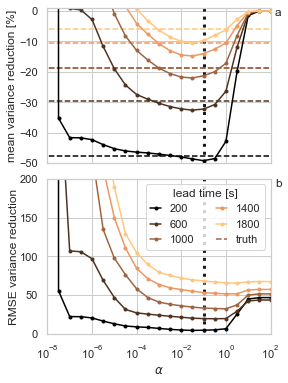

In [102]:
fig,ax=plt.subplots(2,1,figsize=(4,6),sharex='all')

for t in range(ndt_steps):
    ax[0].plot(alpha_vec,es_alpha[:,t]/total[t]*100,label=str(t_vec[t]),color=plt.cm.copper(t/(ndt_steps-1)),marker='.')
    ax[0].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)))
    
    ax[1].plot(alpha_vec,rmse_es_alpha[:,t]*real[t],label=str(t_vec[t]),color=plt.cm.copper(t/(ndt_steps-1)),marker='.')
    
    
    #plt.hlines(es[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle=':',color=plt.cm.copper(t/(ndt_steps-1)))
t=2
ax[0].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)),label='truth')
ax[1].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)),label='truth')

ax[0].vlines(alpha_default,-1000,1000,linestyle=':',color='k',lw=3)
ax[1].vlines(alpha_default,-1000,1000,linestyle=':',color='k',lw=3)

#plt.legend(title='lead time [s]',bbox_to_anchor=(1,1))
# ax[0].legend(title='lead time [s]',ncol=2,bbox_to_anchor=(2,1),loc='upper right')
ax[1].legend(title='lead time [s]',ncol=2,loc='upper right',handlelength=1)
ax[0].set_xscale('log')
# ax[0].set_xlabel(r'$\alpha$')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel('RMSE variance reduction',labelpad=0.1)
ax[0].set_ylabel('mean variance reduction [%]')
ax[0].set_ylim(top=1,bottom=-50)
ax[1].set_ylim(top=200,bottom=0)
ax[0].set_xlim(left=1e-8,right=100)
label_axes_abcd(fig,loc=(1.02,0.95))
plt.subplots_adjust(hspace=0.1)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[0].yaxis.get_label().set_verticalalignment("baseline")
# plt.legend(title='lead time [s]',bbox_to_anchor=(-0.05,1.05,1,0.1),ncol=3)

# Ensemble size plot.
This again requires running a large ensemble and it takes about 30 minutes to run everything, so I reload the conducted experiments instead. uncomment the ensemble_plotter commands below to show the full ensemble 

In [22]:
"""
initialize model and data assimilation setup using the default values
"""

m_const = set_model_constants_22()
da_const = set_da_constants_22(nens=512,ncyc=100)
sat_operator = reflectance_simulator


In [25]:

# slight difference now, instead of running a new state for each ensemble size, i instead first run the max size ensemble, and then randomly select the desired number of ensembles from the large state.
# This is to avoid having differences in the default model run overpower the differences between how many ensembles are used for the vr  test

n_steps=8
ens_values = 2**np.arange(2,n_steps+2)
ens_values = ens_values.astype(int)
#da_const['nens'] = ens_values[-1]
ens_values

array([  4,   8,  16,  32,  64, 128, 256, 512])

In [26]:
%%time
# Run the model
states_512   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


CPU times: user 16.4 s, sys: 371 ms, total: 16.7 s
Wall time: 4.25 s


In [59]:
# fig, ax = ensemble_plotter_22(states_512,m_const,da_const,t_end=3,t_start=1)
# fig, ax = ensemble_plotter_22(states_512,m_const,da_const,t_end=29,t_start=27)


<!-- a_file = open("plot-data/state_letkf_512_1220.pkl", "rb") -->
<!-- states_512 = pickle.load(a_file) -->
<!-- a_file.close() -->

In [81]:
# %%time

# t_start= 40
# t_end = 100
# n_rand = 15
# n_samples = (t_end-t_start)*n_rand
# counter =n_samples
# vr_real       = np.zeros([n_steps,n_samples]) 
# vr_es         = np.zeros([n_steps,n_samples]) 
# vr_is_ca      = np.zeros([n_steps,n_samples]) 
# var_total     = np.zeros([n_steps,n_samples]) 
# for i in range(n_steps): 
#     n_ens=ens_values[i]
#     for t in range(t_start,t_end):
#         for r in range(n_rand):
#             n = (t-t_start)*n_rand+r
#             np.random.seed(n)
#             # selecting random ensemble members for the ensemble
#             idx_ens = randomized_obs_loc(n_ens,start=0,end=ens_values[-1],seed=n)
#             truth_idx = r
            
#             da_const_vr['nens'] = n_ens
            
            
#             vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_512[0]['bg'][t][:,idx_ens],
#                                 states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                 obs_seed=counter,model_seed=counter,alpha=alpha_default)
                                                
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_es[i,n]     = vr_t
#             vr_real[i,n]   = vr_r
#             vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states_512[0]['bg'][t][:,:],
#                             states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                                    advect_flag=1,quad_state=quad,
#                                                                    obs_seed=counter,model_seed=counter)
#             vr_is_ca[i,n]  = vr_t
            
            
#     print('completed nens:',ens_values[i])

completed nens: 4
completed nens: 8
completed nens: 16
completed nens: 32
completed nens: 64
completed nens: 128
completed nens: 256
completed nens: 512
CPU times: user 4min 28s, sys: 4.17 s, total: 4min 32s
Wall time: 1min 8s


In [20]:
# # got to put this in a dictionary, otherwise this is just to many variables
# dict_raw = {

# 'vr_es   ':vr_es   ,
# 'vr_is_ca':vr_is_ca,
# 'vr_real ':vr_real ,
# 'var_total':var_total,
# 'ens_values':ens_values
# }

a_file = open("plot-data/dict_raw_sqenkf_ens_0401.pkl", "wb")
pickle.dump(dict_raw, a_file)
a_file.close()

a_file = open("plot-data/state_letkf_512_1220.pkl", "wb")
pickle.dump(states_512, a_file)
a_file.close()

### Load data

In [12]:
a_file = open("plot-data/ensemble-size-OSSEs.pkl",'rb')
bla=pickle.load(a_file)
dict_raw=bla
a_file.close()
vr_es      =dict_raw['vr_es   ']
vr_is_ca   =dict_raw['vr_is_ca']
vr_real    =dict_raw['vr_real ']
var_total  =dict_raw['var_total']
ens_values =dict_raw['ens_values']

counter = vr_real.shape[1]
n_steps = vr_real.shape[0]
vr_real.shape


(8, 900)

In [13]:
es    =np.sum(vr_es    ,axis=1)/counter#/var_total
is_ca =np.sum(vr_is_ca ,axis=1)/counter#/var_total
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter

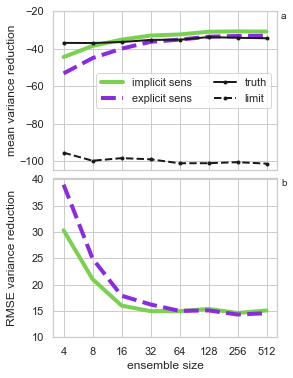

In [14]:
#Lets see what changes when we change the localization used to create the background
fig,ax = plt.subplots(2,1,figsize=(4,6),sharex='all')
ax[0].plot( is_ca  , lw=4,alpha=1.,label='implicit sens',color=plt.cm.viridis(0.8))
ax[0].plot( es     , lw=4,alpha=1.0,label='explicit sens'              ,color='blueviolet',ls='--')      
ax[0].plot( real     , lw=2,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[0].plot(-total    , lw=2,alpha=1,  color='k',ls='--',marker='.',label='limit')
ax[1].plot(rmse_is_ca*real    , lw=4,alpha=1.0,label='implicit sensitivity',color=plt.cm.viridis(0.8))
ax[1].plot(rmse_es*real       , lw=4,alpha=1.0,label='explicit sensitivity'              ,color='blueviolet',ls='--',zorder=2)      


ax[1].set_xlabel('ensemble size');
ax[0].set_ylabel('mean variance reduction');
ax[1].set_ylabel('RMSE variance reduction');

ax[0].set_xticks(np.arange(n_steps));
ax[0].set_xticklabels(ens_values);
ax[1].set_ylim(bottom=10)
ax[0].set_ylim(top=-20)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc='upper center',ncol=6)
#ax[0].legend(bbox_to_anchor=(-0.3,1.05),loc='lower left',ncol=5);
ax[0].legend(loc='center right',ncol=2);
#ax[1].legend(lines,labels)#ncol=2,bbox_to_anchor=(1.3,.05),loc='lower left').set_zorder(100);
plt.subplots_adjust(hspace=0.05)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[1].yaxis.get_label().set_verticalalignment("baseline")
label_axes_abcd(fig,loc=(1.02,0.95))

In [28]:
%%time
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests

t_start= 40
t_end = 100
n_rand = 15
n_samples = (t_end-t_start)*n_rand
counter =n_samples
vr_real       = np.zeros([n_steps,n_samples]) 
vr_es         = np.zeros([n_steps,n_samples]) 
vr_is_ca      = np.zeros([n_steps,n_samples]) 
var_total     = np.zeros([n_steps,n_samples]) 
for i in range(n_steps): 
    n_ens=ens_values[i]
    for t in range(t_start,t_end):
        for r in range(n_rand):
            n = (t-t_start)*n_rand+r
            np.random.seed(n)
            # selecting random ensemble members for the ensemble
            idx_ens = randomized_obs_loc(n_ens,start=0,end=ens_values[-1],seed=n)
            truth_idx = r
            
            da_const_vr['nens'] = n_ens
            
            
            vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_512[0]['bg'][t][:,idx_ens],
                                states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
                                                obs_seed=counter,model_seed=counter,alpha=alpha_default)
                                                
            var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
            vr_es[i,n]     = vr_t
            vr_real[i,n]   = vr_r
            vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states_512[0]['bg'][t][:,:],
                            states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
                                                                   advect_flag=1,quad_state=quad,
                                                                   obs_seed=counter,model_seed=counter)
            vr_is_ca[i,n]  = vr_t
            
            
    print('completed nens:',ens_values[i])

completed nens: 4
completed nens: 8
completed nens: 16
completed nens: 32


/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2275: ComplexWarning: Casting complex values to real discards the imaginary part
  fc[:,i]    = linear_advection_model(an[:,i],u_ens,dhdt_ens,m_const["dx"],da_const["dt"],da_const["nt"])
/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2423: ComplexWarning: Casting complex values to real discards the imaginary part
  an_response[n] = func_J(quad_state["an"][:,n])
/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2698: ComplexWarning: Casting complex values to real discards the imaginary part
  an_response[n] = np.sum(response_s * np.power(quad_state["an"][:,n],response_c))


completed nens: 64
completed nens: 128
completed nens: 256
completed nens: 512
CPU times: user 25min 52s, sys: 30.6 s, total: 26min 23s
Wall time: 6min 35s


In [31]:
es    =np.sum(vr_es    ,axis=1)/counter#/var_total
is_ca =np.sum(vr_is_ca ,axis=1)/counter#/var_total
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter

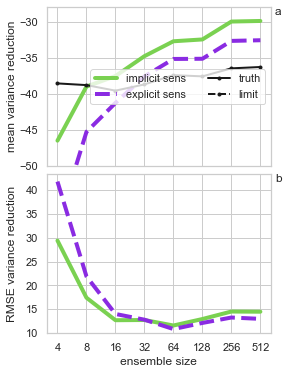

In [32]:
#Lets see what changes when we change the localization used to create the background
fig,ax = plt.subplots(2,1,figsize=(4,6),sharex='all')
ax[0].plot( is_ca  , lw=4,alpha=1.,label='implicit sens',color=plt.cm.viridis(0.8))
ax[0].plot( es     , lw=4,alpha=1.0,label='explicit sens'              ,color='blueviolet',ls='--')      
ax[0].plot( real     , lw=2,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[0].plot(-total    , lw=2,alpha=1,  color='k',ls='--',marker='.',label='limit')
ax[1].plot(rmse_is_ca*real    , lw=4,alpha=1.0,label='implicit sensitivity',color=plt.cm.viridis(0.8))
ax[1].plot(rmse_es*real       , lw=4,alpha=1.0,label='explicit sensitivity'              ,color='blueviolet',ls='--',zorder=2)      


ax[1].set_xlabel('ensemble size');
ax[0].set_ylabel('mean variance reduction');
ax[1].set_ylabel('RMSE variance reduction');

ax[0].set_xticks(np.arange(n_steps));
ax[0].set_xticklabels(ens_values);
ax[1].set_ylim(bottom=10)
ax[0].set_ylim(top=-28,bottom=-50)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc='upper center',ncol=6)
#ax[0].legend(bbox_to_anchor=(-0.3,1.05),loc='lower left',ncol=5);
ax[0].legend(loc='center right',ncol=2);
#ax[1].legend(lines,labels)#ncol=2,bbox_to_anchor=(1.3,.05),loc='lower left').set_zorder(100);
plt.subplots_adjust(hspace=0.05)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[1].yaxis.get_label().set_verticalalignment("baseline")
label_axes_abcd(fig,loc=(1.02,0.95))

In [38]:
%%time
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests
alpha_default =0.000001
t_start= 40
t_end = 100
n_rand = 15
n_samples = (t_end-t_start)*n_rand
counter =n_samples
vr_real       = np.zeros([n_steps,n_samples]) 
vr_es         = np.zeros([n_steps,n_samples]) 
vr_is_ca      = np.zeros([n_steps,n_samples]) 
var_total     = np.zeros([n_steps,n_samples]) 
for i in range(n_steps): 
    n_ens=ens_values[i]
    for t in range(t_start,t_end):
        for r in range(n_rand):
            n = (t-t_start)*n_rand+r
            np.random.seed(n)
            # selecting random ensemble members for the ensemble
            idx_ens = randomized_obs_loc(n_ens,start=0,end=ens_values[-1],seed=n)
            truth_idx = r
            
            da_const_vr['nens'] = n_ens
            
            
            vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_512[0]['bg'][t][:,idx_ens],
                                states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
                                                obs_seed=counter,model_seed=counter,alpha=alpha_default)
                                                
            var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
            vr_es[i,n]     = vr_t
            vr_real[i,n]   = vr_r
            vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states_512[0]['bg'][t][:,:],
                            states_512[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
                                                                   advect_flag=1,quad_state=quad,
                                                                   obs_seed=counter,model_seed=counter)
            vr_is_ca[i,n]  = vr_t
            
            
    print('completed nens:',ens_values[i])

completed nens: 4
completed nens: 8
completed nens: 16
completed nens: 32


/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2275: ComplexWarning: Casting complex values to real discards the imaginary part
  fc[:,i]    = linear_advection_model(an[:,i],u_ens,dhdt_ens,m_const["dx"],da_const["dt"],da_const["nt"])
/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2423: ComplexWarning: Casting complex values to real discards the imaginary part
  an_response[n] = func_J(quad_state["an"][:,n])
/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:2698: ComplexWarning: Casting complex values to real discards the imaginary part
  an_response[n] = np.sum(response_s * np.power(quad_state["an"][:,n],response_c))


completed nens: 64
completed nens: 128
completed nens: 256
completed nens: 512
CPU times: user 25min 51s, sys: 31.1 s, total: 26min 22s
Wall time: 6min 35s


In [40]:
es    =np.sum(vr_es    ,axis=1)/counter#/var_total
is_ca =np.sum(vr_is_ca ,axis=1)/counter#/var_total
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter

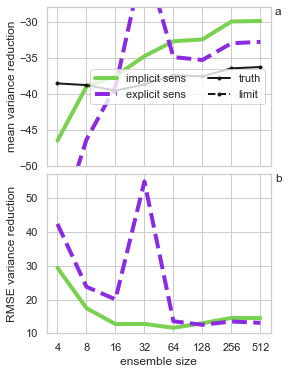

In [41]:
#Lets see what changes when we change the localization used to create the background
fig,ax = plt.subplots(2,1,figsize=(4,6),sharex='all')
ax[0].plot( is_ca  , lw=4,alpha=1.,label='implicit sens',color=plt.cm.viridis(0.8))
ax[0].plot( es     , lw=4,alpha=1.0,label='explicit sens'              ,color='blueviolet',ls='--')      
ax[0].plot( real     , lw=2,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[0].plot(-total    , lw=2,alpha=1,  color='k',ls='--',marker='.',label='limit')
ax[1].plot(rmse_is_ca*real    , lw=4,alpha=1.0,label='implicit sensitivity',color=plt.cm.viridis(0.8))
ax[1].plot(rmse_es*real       , lw=4,alpha=1.0,label='explicit sensitivity'              ,color='blueviolet',ls='--',zorder=2)      


ax[1].set_xlabel('ensemble size');
ax[0].set_ylabel('mean variance reduction');
ax[1].set_ylabel('RMSE variance reduction');

ax[0].set_xticks(np.arange(n_steps));
ax[0].set_xticklabels(ens_values);
ax[1].set_ylim(bottom=10)
ax[0].set_ylim(top=-28,bottom=-50)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc='upper center',ncol=6)
#ax[0].legend(bbox_to_anchor=(-0.3,1.05),loc='lower left',ncol=5);
ax[0].legend(loc='center right',ncol=2);
#ax[1].legend(lines,labels)#ncol=2,bbox_to_anchor=(1.3,.05),loc='lower left').set_zorder(100);
plt.subplots_adjust(hspace=0.05)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[1].yaxis.get_label().set_verticalalignment("baseline")
label_axes_abcd(fig,loc=(1.02,0.95))

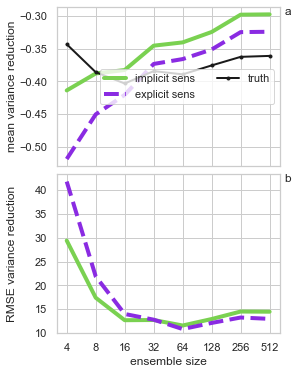

In [33]:
#Lets see what changes when we change the localization used to create the background
fig,ax = plt.subplots(2,1,figsize=(4,6),sharex='all')
ax[0].plot( is_ca/total  , lw=4,alpha=1.,label='implicit sens',color=plt.cm.viridis(0.8))
ax[0].plot( es/total     , lw=4,alpha=1.0,label='explicit sens'              ,color='blueviolet',ls='--')      
ax[0].plot( real/total       , lw=2,alpha=1,  color='k',ls='-',marker='.',label='truth')
# ax[0].plot(-total    , lw=2,alpha=1,  color='k',ls='--',marker='.',label='limit')
ax[1].plot(rmse_is_ca*real    , lw=4,alpha=1.0,label='implicit sensitivity',color=plt.cm.viridis(0.8))
ax[1].plot(rmse_es*real       , lw=4,alpha=1.0,label='explicit sensitivity'              ,color='blueviolet',ls='--',zorder=2)      


ax[1].set_xlabel('ensemble size');
ax[0].set_ylabel('mean variance reduction');
ax[1].set_ylabel('RMSE variance reduction');

ax[0].set_xticks(np.arange(n_steps));
ax[0].set_xticklabels(ens_values);
ax[1].set_ylim(bottom=10)
# ax[0].set_ylim(top=-20)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc='upper center',ncol=6)
#ax[0].legend(bbox_to_anchor=(-0.3,1.05),loc='lower left',ncol=5);
ax[0].legend(loc='center right',ncol=2);
#ax[1].legend(lines,labels)#ncol=2,bbox_to_anchor=(1.3,.05),loc='lower left').set_zorder(100);
plt.subplots_adjust(hspace=0.05)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[1].yaxis.get_label().set_verticalalignment("baseline")
label_axes_abcd(fig,loc=(1.02,0.95))

In [41]:
# Graveyard to be removed

In [39]:
def vr_scatter_v4(vr_tot1,vr_rea1,vr_tot2,vr_rea2,vr_tot3,vr_tot4,alpha=0.3,alpha2=0.5,color1='blueviolet',color2=plt.cm.viridis(0.8),
                  label1='',label2='',label3='',llabel1='explicit sens',llabel2='implicit sens'):
    """
    Just a 2x2 scatterplot with shared axis and a linear regressions """
    
    fig, ax = plt.subplots(2,2,figsize=(5.5,5.5),sharex='all',sharey='all')
    
    color = color1
    vr_rea = vr_rea1
    vr_tot = vr_tot1
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[0,0].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[0,0].scatter(vr_rea,vr_tot,c=color,alpha=alpha,s=5,zorder=1,label=llabel1)
    ax[0,0].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[0,0].set_aspect('equal', 'box')
    ax[0,0].legend(loc='lower center')
    
            
    vr_rea = vr_rea2
    vr_tot = vr_tot2
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[0,1].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[0,1].scatter(vr_rea,vr_tot,c=color,alpha=alpha,s=5,zorder=1)
    ax[0,1].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[0,1].set_aspect('equal', 'box')
    
    color = color2
    vr_rea = vr_rea1
    vr_tot = vr_tot3
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[1,0].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[1,0].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1,label=llabel2)
    ax[1,0].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[1,0].set_aspect('equal', 'box')
    ax[1,0].legend(loc='lower center')
    
            
    vr_rea = vr_rea2
    vr_tot = vr_tot4
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[1,1].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[1,1].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1)
    ax[1,1].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[1,1].set_aspect('equal', 'box')
            
    
    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    
    ax[1,0].set_xlabel('variance reduction')
    ax[1,1].set_xlabel('variance reduction')
    ax[1,0].set_ylabel('estimated var reduction')
    ax[0,0].set_ylabel('estimated var reduction')
    
    ax[0,0].set_title(label1)
    ax[0,1].set_title(label2)
    
    x_max = np.max(np.hstack([vr_rea1,vr_rea2,vr_tot1,vr_tot2]))
    x_min = np.min(np.hstack([vr_rea1,vr_rea2,vr_tot1,vr_tot2]))
    
   
    ax[0,0].set_xlim(x_min,x_max)
    ax[0,0].set_ylim(x_min,x_max)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    return fig, ax